# Bayesian Model Averaging with `numpyro`

## Example: Poisson Dataset
We generate Poisson samples from a rate function that has a Gaussian shape. This is the same dataset that is used in the [sparse-tinygp](https://github.com/edwarddramirez/sparse-tinygp) repo. Specifically, the true data is drawn from the following distribution:

$$
\begin{aligned}
y_i & \sim \mathrm{Pois}[\lambda(x_i)] \\
\lambda(x_i) & = N \exp \left [-\frac{(x_i - \mu)}{2 \sigma^{2}} \right ],
\end{aligned}
$$
where $\mu = 0$, $\sigma = \pi$, and $N = 10$.

In [17]:
import sys
sys.path.append("..")
from utils import custom
from utils.custom import log_like_poisson

import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting
import corner # for corner plots
from tqdm import tqdm # for progress bars

import jax # for faster numerical operations
import jax.numpy as jnp # for numpy-like syntax
from jax.scipy import stats
from jax import jit
from jax.random import poisson

import numpyro # for inference and probabilistic programming
import numpyro.distributions as dist
from numpyro.infer import Predictive
from numpyro.infer.util import log_density
from numpyro.handlers import block, seed, trace

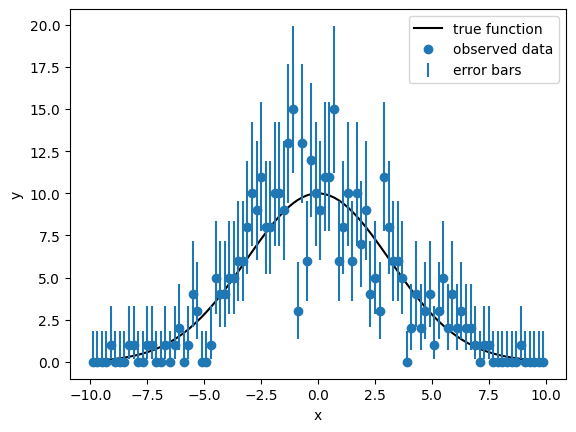

In [19]:
# parameters
p_tr = [0., np.pi, 10.]
mu_tr, sigma_tr, N_tr = p_tr

# generate data
x_bin = jnp.linspace(-10,10,101) # 10 random points between -1 and 1
x = 0.5 * (x_bin[:-1] + x_bin[1:])
log_rate = -(x-mu_tr)**2. / (2. * sigma_tr**2.)
y = N_tr * jnp.exp(log_rate)
y_obs = jax.random.poisson(jax.random.PRNGKey(23),y)

# estimate error bars
yerr = jnp.array([custom.poisson_interval(k) for k in y_obs.T]).T

# plot data with error bars
plt.plot(x, y, 'k', label='true function')
plt.plot(x, y_obs, 'o', label='observed data')
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', label='error bars')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Bayesian Model Averaging

### Review of Bayesian Model Averaging and Implementation
Suppose we are fitting the data with $M$ models $\{\mathcal{M}_{i}\}_{i}$. For simplicity, suppose each $\mathcal{M}_{i}$ share the same latent variables $z$. In Bayesian Model Averaging, the result of *average posterior* of the models given the data $y$ is given by:
$$ p(z|y) = \sum_{i=1}^{N} \ p(z|y, \mathcal{M}_i) \ p(\mathcal{M_i} | y), $$
where $p(z|y, \mathcal{M}_i)$ is the posterior corresponding to the model $\mathcal{M}_i$ and $p(\mathcal{M_i} | y)$ is the probability of the model given the data. These latter terms acts as weights on each single-model posterior. 

To compute the first term in the sum, we just need to fit each model to the data using an inference technique of our choice. We opt for SVI, as the name of the repo suggests. For computing the second term, we use Bayes' Theorem:
$$ p(\mathcal{M}_{i} | y) = \frac{p(y | \mathcal{M}_i) \ p(\mathcal{M}_i)}{\sum_{j = 1}^{N} p(y | \mathcal{M}_j) \ p(\mathcal{M}_j) }, $$
where $p(\mathcal{M}_{i})$ denotes our priors on the models. The likelihood term (i.e., the evidence of the model) is notoriously difficult to compute. We compute it using MC importance sampling:
$$
\begin{aligned}
    p(y | \mathcal{M}_i) & = \int dz \ p(y | z, \mathcal{M}_i) \ p(z | \mathcal{M}_i), \\
    & = \mathbb{E}_{q(z)} \left[ \frac{p(y|z, \mathcal{M}_i) \ p(z | \mathcal{M}_i)}{q(z)} \right]
\end{aligned}
$$
where the first term is the posterior predictive distribution corresponding to the model and the second is the prior distribution assumed by the model. We take the prior to be unbiased; i.e., $p(\mathcal{M_{i}}) = M^{-1}$. The term $q(z)$ is the *importance distribution*, which gives us a better approximation of the evidence if it coincides with the posterior distribution. We take the SVI guide (or variational distribution) as our importance distribution, as it approximates the true posterior of the model.

### Implementation
Our set of Poisson models $\mathcal{M_j}$ to fit the data $\mathbf{y}$ are given as follows:
$$ 
\begin{aligned}
    y_i & \sim \mathrm{Pois}[\lambda(x_i) | \mathcal{M_j}] \\
    \lambda(x_i | \mathcal{M_j}) & = N \exp \left [-\frac{(x_i - \mu_j)}{2 \sigma^{2}} \right ] \\
    \sigma & \sim U[0.001, 20] \\
    N & \sim U[0.001, 100]
\end{aligned}
$$
Therefore, they correspond to Gaussian rate functions centered at different mean parameters $\mu_{j}$. They share the same latent space $(\sigma, N)$ and the same priors on those variables.

## Fit Each Model 
This gives us the $p(y | \mathcal{M_i})$ terms in the model average. 

In [20]:
@jit
def log_like_poisson(mu, data):
    return dist.discrete.Poisson(mu).log_prob(data)

def model(x, y=None, mu = None):
    '''
    1D Poisson regression with a simple Gaussian rate model with fixed mu

    Parameters
    ----------
    x : array
        x values (where observations are made)
    y : array
        y values (observations)
    mu : float
        mean parameter of the Gaussian rate model
    '''
    # priors
    if mu == None: # allows for mu to be a latent variable
        mu = numpyro.sample(
            "mu", dist.Uniform(-10, 10)
        )
    sigma = numpyro.sample(
        "sigma", dist.Uniform(1e-3, 20.)
    )
    N = numpyro.sample(
        "N", dist.Uniform(1e-3, 100.)
    )

    # rate model
    rate = N * jnp.exp(-(x-mu)**2. / (2. * sigma**2.))
    
    # log likelihood
    if y != None:
        numpyro.factor("obs", log_like_poisson(rate, y))

In [21]:
from numpyro.infer.autoguide import AutoMultivariateNormal
from functools import partial

# list of mu values of each model
mu_list = jnp.arange(-1.,1. + 0.25,0.25)

# define models, guides, and svi objects through list comprehension
# notice, we are using the partial function to pass in the mu value for each model
# so, we don't need to specify mu as an argument during inference (next cell)
Nm = len(mu_list)
models = [partial(model, mu=mu_list[k]) for k in range(Nm)]
guides = [AutoMultivariateNormal(m) for m in models]
optim = numpyro.optim.Adam(0.01)
svis = [numpyro.infer.SVI(models[k], guides[k], optim, numpyro.infer.Trace_ELBO(20)) for k in range(Nm)]

In [22]:
# perform SVI for each model
rng_keys = jax.random.split(jax.random.PRNGKey(0), Nm)
svi_results_list = [svis[n].run(rng_keys[n], 10000, x, y_obs) for n in range(Nm)]

100%|██████████| 10000/10000 [00:04<00:00, 2135.90it/s, init loss: 1507.1869, avg. loss [9501-10000]: 195.3107]


In [23]:
# use Predictive to generate samples from the guide 
# this method was the easiest one to implement that avoids jax tracer leaks 
def generate_rate(rng_key, mu, num_samples, guide, params, x):
    temp_pred = Predictive(guide, num_samples = num_samples, params = params)
    temp_samples = temp_pred(rng_key, x)
    if mu == None:
        temp_rate = temp_samples['N'][:,None] * np.exp(-(x[None,:]-temp_samples['mu'][:,None])**2. / (2. * temp_samples['sigma'][:,None]**2.))
    else:
        temp_rate = temp_samples['N'][:,None] * np.exp(-(x[None,:]-mu)**2. / (2. * temp_samples['sigma'][:,None]**2.))
    return temp_samples, temp_rate

In [24]:
# generate posterior samples from each model and combine to list
samples_list = [] ; rate_list = []
rng_key = jax.random.PRNGKey(121)
num_samples = 100000
for n in tqdm(range(Nm)):
    key, rng_key = jax.random.split(rng_key)

    mu = mu_list[n]
    svi_results = svi_results_list[n]
    guide = guides[n]
    params = svi_results.params
    temp_samples, temp_rate = generate_rate(key, mu, num_samples, guide, params, x)

    samples_list.append(temp_samples)
    rate_list.append(temp_rate)

rate_list = jnp.array(rate_list)

100%|██████████| 9/9 [00:27<00:00,  3.09s/it]


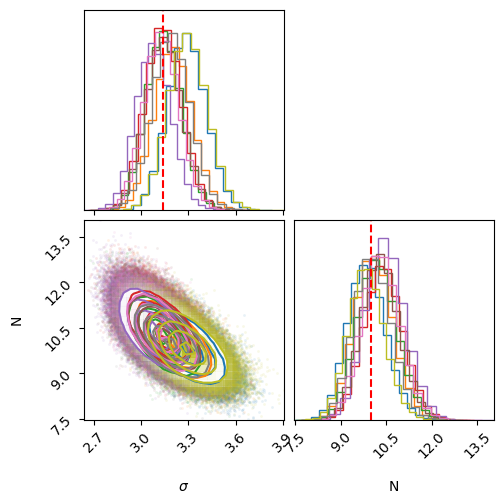

In [25]:
# display posterior samples in a corner plot
temp_samples_tot = np.zeros((num_samples,2))
for n in range(Nm):
    temp_samples = samples_list[n]
    temp_samples_tot[:,0] = temp_samples['sigma']
    temp_samples_tot[:,1] = temp_samples['N']

    ccode = 'C' + str(n)
    if n == 0:
        fig = corner.corner(np.array(temp_samples_tot), labels = ['$\\sigma$','N'], color = ccode)
    else:
        corner.corner(np.array(temp_samples_tot), labels = ['$\\sigma$','N'], color = ccode, fig = fig)
axes = np.array(fig.axes).reshape((2, 2))
for i in range(2):
    ax = axes[i,i]
    ax.axvline(p_tr[i+1], color='red', linestyle='--')

Text(0, 0.5, 'y')

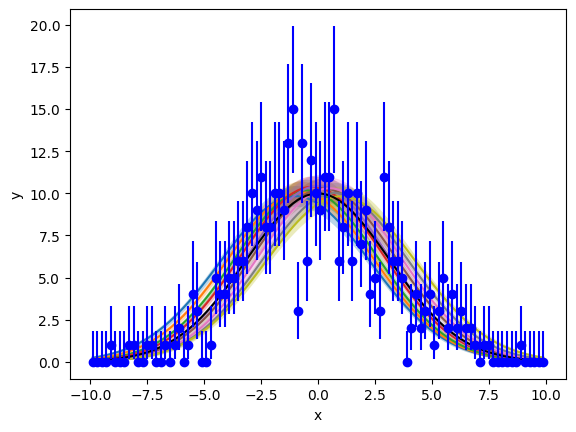

In [26]:
# plot posterior means and 68% confidence region corresponding to each model
for n in range(Nm):
    rate = rate_list[n]
    q = np.percentile(rate, [16, 50, 84], axis=0)

    ccode = 'C' + str(n)

    # plot guide (posterior approximation)
    plt.plot(x, q[1], color=ccode, label="$\\mu = $ "+ str(mu_list[n]))
    plt.fill_between(x, q[0], q[2], alpha=0.3, lw=0, color=ccode)

plt.plot(x, y, 'k', label='true function')
plt.plot(x, y_obs, 'bo', label='observed data')
plt.errorbar(x, y_obs, yerr = yerr, c = 'b', fmt = 'none', label='error bars')

# plt.legend()
plt.xlabel("x")
plt.ylabel("y")

## Compute the Evidence for Each Model
Remembering that we will take a uniform prior on the models, the evidences $p(y | \mathcal{M_j})$ will give us the weights of each model in the model average. Recall,
$$
\begin{aligned}
    p(y | \mathcal{M}_i) & = \mathbb{E}_{q(z)} \left[ \frac{p(y|z, \mathcal{M}_i) \ p(z | \mathcal{M}_i)}{q(z)} \right] \\
    & = \mathbb{E}_{q(z)} \left[ \frac{p(y,z | \mathcal{M}_i)}{q(z)} \right],
\end{aligned}
$$
where we chose $q(z)$ to be the SVI guide. To estimate this quantity as an MC estimate, we draw $z$-samples from the SVI guide and use them to compute the densities given in the numerator and denominator of the expression above. This is achieved using the `log_density` utility function. This isn't the exact way `log_density` was intended to be used, so it took some hacking to get right. Moreover, we needed to apply `jax.vmap` to the `log_density` function to speed up the calculation. 

Credit to [fehiepsi](https://github.com/fehiepsi) for helping me figure this out. See the following [numpyro forum post](https://forum.pyro.ai/t/log-probability-of-guide-in-constrained-space/5950).

In [27]:
# Let's make a function that computes the log likelihood each model
# using the guide as our importance distribution.
# We use the guide samples that we generated earlier to estimate the evidence.

def body_fn_model(samples, model, x, y):
    seeded_model = seed(model, jax.random.PRNGKey(0))
    sigma, N, _ = samples
    ll, _ = log_density(seeded_model, model_args = (x,), model_kwargs = {'y' : y}, params = {'mu': mu, 'sigma': sigma, 'N': N})
    return ll
body_fn_model_vec = jax.vmap(body_fn_model, in_axes = (0, None, None, None))

def body_fn_guide(samples, guide, x, y, svi_params):
    seeded_guide = seed(guide, jax.random.PRNGKey(0))
    params_aug = svi_params.copy()
    sigma, N, _auto_latent = samples
    params_aug['sigma'] = sigma
    params_aug['N'] = N
    params_aug['_auto_latent'] = _auto_latent
    ll, _ = log_density(seeded_guide, model_args = (x,), model_kwargs = {'y' : y}, params = params_aug)
    return ll
body_fn_guide_vec = jax.vmap(body_fn_guide, in_axes = (0, None, None, None, None))

keys = ['sigma', 'N', '_auto_latent']
Nk = len(keys)

log_ratio_list = [] 
ratio_list = []
for n in tqdm(range(Nm)):
    samples = samples_list[n]
    samples_proc = []
    model = models[n]
    guide = guides[n]
    svi_results = svi_results_list[n]
    for k in range(Nk):
        key = keys[k]
        samples_proc.append(samples[key])

    numerator_list = body_fn_model_vec(samples_proc, model, x, y_obs)
    denominator_list = body_fn_guide_vec(samples_proc, guide, x, None, svi_results.params)

    numerator_list = np.array(numerator_list)
    denominator_list = np.array(denominator_list)
    
    log_ratio = numerator_list - denominator_list
    ratio = np.exp(np.longdouble(log_ratio))

    log_ratio_list.append(log_ratio)
    ratio_list.append(ratio)

100%|██████████| 9/9 [00:00<00:00, 16.22it/s]


Evidence Values:  [1.77010672e-85 6.40767009e-82 2.97123659e-79 1.32670035e-77
 4.74283929e-77 1.27745412e-77 2.76442594e-79 5.77769688e-82
 1.55346648e-85]


Text(0, 0.5, 'log evidence')

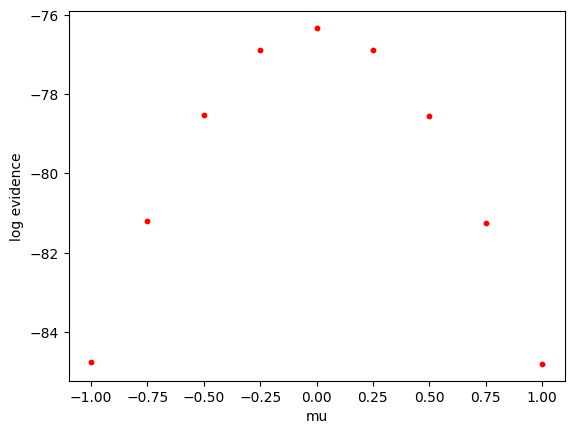

In [28]:
# compute the evidence by taking the mean of the ratios sampled above
ratio_list = np.array(ratio_list)
evidences = np.mean(ratio_list, axis = 1)
weights = evidences / np.sum(evidences) # weights for unbiased model prior

# notice how small the evidence values are, that's why we needed to specify the ratio quantities as longdoubles in the above cell
print('Evidence Values: ', evidences)

# plot the log evidence values versus mu
plt.scatter(mu_list, np.log10(evidences), s = 10., c = 'r', label = 'log evidence')
plt.xlabel('mu')
plt.ylabel('log evidence')

As expected, a value closer to the true $\mu$ value of $0$ gives the highest evidence and hence is most preferred by the model average. 

  0%|          | 0/1000 [00:00<?, ?it/s]/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1000/1000 [00:00<00:00, 15738.24it/s]


Text(0, 0.5, 'Mean Evidence')

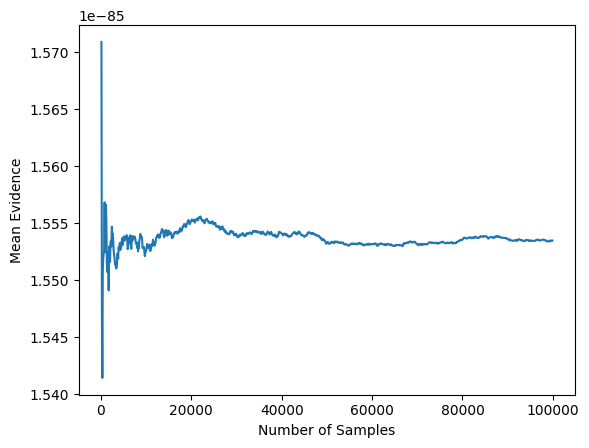

In [29]:
# Check convergence of the evidence with respect to the number of samples used in the MC estimate,
# using the final model in the previous loop as an example
n_list = []
mean_list = []
for n in tqdm(range(0, num_samples, 100)):
    mean = np.mean(ratio[:n])
    n_list.append(n)
    mean_list.append(mean)

plt.plot(n_list, mean_list)
plt.xlabel('Number of Samples')
plt.ylabel('Mean Evidence')

## Sampling from the Model Average


In [30]:
# below, we require the following quantities to be jax arrays
mu_list = jnp.arange(-1.,1. + 0.25,0.25)
weights = jnp.array(weights, dtype = jnp.float32)

In [31]:
# As before, we use a list comprehension to sample from each guide separately
pred_list = [Predictive(guides[n], num_samples = 1, params = svi_results_list[n].params) for n in range(Nm)] 
sample_fct_list = [ (lambda rng_key, x, k = k : pred_list[k](rng_key, x)) for k in range(len(pred_list)) ] 

# allows us to sample from a model of our choice indexed by n (the list index of model_list / mu_list)
# in a JIT-compilable way
def sample_fct_switch(n, rng_key, x):
    sample_fct = lambda n : jax.lax.switch(n, sample_fct_list, rng_key, x)
    return jax.vmap(sample_fct)(n)

# sample from Bayesian Model Average by selecting a model index from the weights
# note: if 
def model_avg_sample(rng_key, mu_list, weights):
    int_key, model_key, poiss_key = jax.random.split(rng_key, 3)
    Nm = len(mu_list)
    nm = jax.random.choice(int_key, jnp.arange(Nm), (1,), p = weights)
    sample = sample_fct_switch(nm, model_key, x)
    _mu = mu_list[nm]
    _N = sample['N']
    _sigma = sample['sigma']
    lam = _N.T * jnp.exp(-(x[:,None]-_mu[None,:])**2. / (2. * _sigma.T**2.))
    y = numpyro.deterministic('y', poisson(poiss_key, lam))

    dict_keys = ['sigma', 'N', 'lam', 'y']
    return dict(zip(dict_keys, [_sigma, _N, lam, y]))

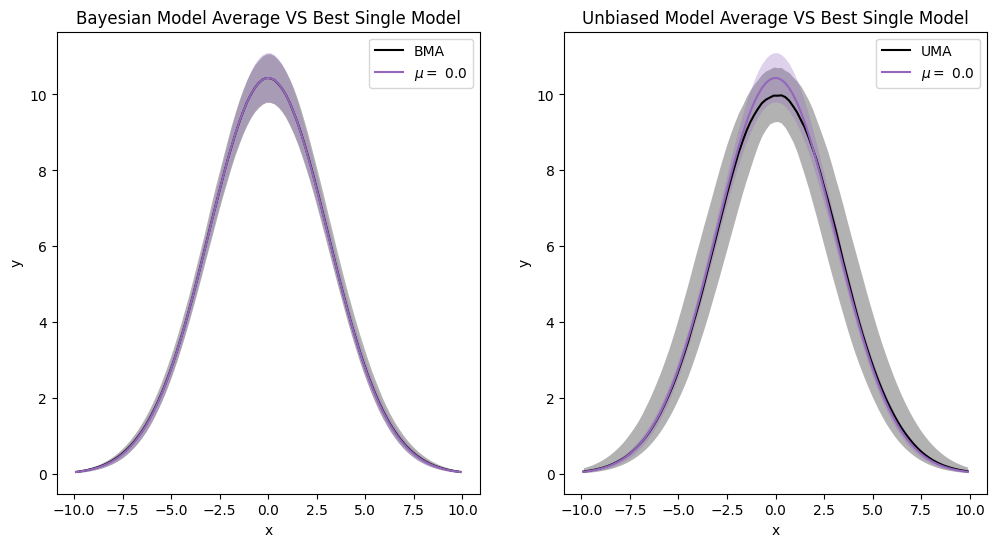

In [33]:
num_samples = 1000
rng_key_vec = jax.random.split(jax.random.PRNGKey(10), num_samples)

# generate samples from the model averaged posterior
bma_model_avg_sample_vec = jax.vmap(lambda rng_key : model_avg_sample(rng_key, mu_list, weights))
bma_samples = bma_model_avg_sample_vec(rng_key_vec)
bma_rate = bma_samples['lam'][:,:,0]
bma_q = np.percentile(bma_rate, [16, 50, 84], axis=0)

# generate samples from the model averaged posterior with uniform weights
unbiased_weights = jnp.ones(Nm) / Nm
unbiased_model_avg_sample_vec = jax.vmap(lambda rng_key : model_avg_sample(rng_key, mu_list, unbiased_weights))
unbiased_samples = unbiased_model_avg_sample_vec(rng_key_vec)
unbiased_rate = unbiased_samples['lam'][:,:,0]
unbiased_q = np.percentile(unbiased_rate, [16, 50, 84], axis=0)

# compare model averages to the best single model posterior
n_best = np.argmax(evidences)
best_rate = rate_list[n_best]
best_q = np.percentile(best_rate, [16, 50, 84], axis=0)
ccode = 'C' + str(n_best)

fig = plt.figure(figsize = (12, 6))

ax = fig.add_subplot(121)
ax.plot(x, bma_q[1], color='k', label='BMA')
ax.fill_between(x, bma_q[0], bma_q[2], alpha=0.3, lw=0, color='k')
ax.plot(x, best_q[1], color=ccode, label="$\\mu = $ "+ str(mu_list[n_best]))
ax.fill_between(x, best_q[0], best_q[2], alpha=0.3, lw=0, color=ccode)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title('Bayesian Model Average VS Best Single Model')
ax.legend()

ax = fig.add_subplot(122)
ax.plot(x, unbiased_q[1], color='k', label='UMA')
ax.fill_between(x, unbiased_q[0], unbiased_q[2], alpha=0.3, lw=0, color='k')
ax.plot(x, best_q[1], color=ccode, label="$\\mu = $ "+ str(mu_list[n_best]))
ax.fill_between(x, best_q[0], best_q[2], alpha=0.3, lw=0, color=ccode)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title('Unbiased Model Average VS Best Single Model')
ax.legend()

As expected, unbiased weights yield higher uncertainties because we're just stacking the individual posteriors together. For the Bayesian Model Average, due to the overwhelmingly higher evidence of the $\mu = 0$ model, it dominates that average.

### Note on Form of Sampler Function
We wrote the `model_avg_sample` function in the way that we did for several reasons. One of the main reasons is that we wanted to be able to perform SVI on the model-averaged posterior itself to fit another parametric model to the model average. Fitting a model to another model is something that I discuss in the `svi-dist-fit` repo. We avoid sharing that code out of making the notebook too complicated.